In [286]:
import sys
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pymysql
import scipy.sparse as sps

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split

In [287]:
db_connection_str = 'mysql+pymysql://root:123@db/invest'
db_connection = create_engine(db_connection_str)

df_clientes = pd.read_sql('SELECT * FROM cli_Clientes', con=db_connection)
df_cliente_produto = pd.read_sql('SELECT * FROM cli_Produtos', con=db_connection)
df_produtos = pd.read_sql('SELECT * FROM Produtos', con=db_connection)

In [288]:
df_cliente_produto.sample(2)

,userid,produtoid,valorrendimento,dataefetivacao
33840,9824,5972,NaN,2019-10-07
18492,8370,71,NaN,2020-01-29


In [289]:
# removendo linhas com userid = 0 -> esses são os produtos que nenhum cliente comprou ainda

df_cliente_produto = df_cliente_produto[df_cliente_produto['userid'] > 0]

In [290]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 48332
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userid           48333 non-null  int64  
 1   produtoid        48333 non-null  int64  
 2   valorrendimento  7216 non-null   float64
 3   dataefetivacao   48272 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ MB


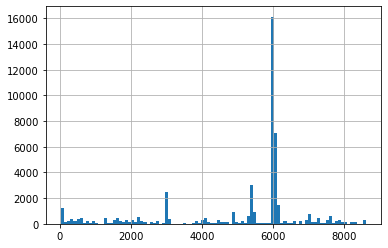

In [291]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [292]:
# analisando os produtos mais populares
df_cliente_produto['produtoid'].value_counts()

5972    15397
6085     4470
5386     3011
6082     2001
6138     1331
        ...  
6106        1
6170        1
134         1
6266        1
5909        1
Name: produtoid, Length: 900, dtype: int64

In [293]:
# o produto mais popular
df_produtos[df_produtos['dataId'] == 5972]

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
5972,5972,SANTANDER SECURITIES SERVICES BRASIL DTVM S.A.,1,None,30.353.590/0001-05,03.502.968/0001-04,None,22.5,O FUNDO tem por objetivo investir em ativos fi...,Qualquer dia,...,Fundo de Renda Fixa,Abertura,None,Aberto,Longo prazo,30.0,30.0,30.0,NaN,None


In [294]:
# vendo os clientes que compraram mais vezes o produto mais popular
df_cliente_produto[df_cliente_produto['produtoid'] == 5972]['userid'].value_counts()

1369     36
736      27
462      22
566      21
2353     20
         ..
1076      1
11321     1
3133      1
1092      1
2049      1
Name: userid, Length: 6927, dtype: int64

In [295]:
# removendo os relacionamentos duplicados (clientes que compraram o mesmo produto mais de uma vez)
df_cliente_produto = df_cliente_produto[['userid','produtoid']].drop_duplicates()

In [296]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30061 entries, 0 to 48332
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     30061 non-null  int64
 1   produtoid  30061 non-null  int64
dtypes: int64(2)
memory usage: 704.6 KB


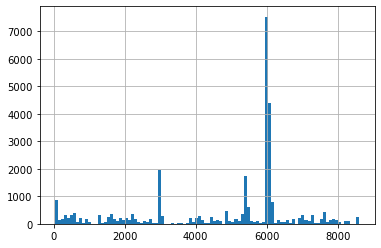

In [297]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [298]:
df_clientes.sample(2)

,userid,userid_aux,idade,genero,estadocivil,billingcity,profissaopessoa,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,...,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira,createddate,dataclienteefetivado
5576,5577,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeb0/lPplNkDjK5bwVY...,25.5,M,S,Passo Fundo,Auxiliar de Escritório e Assemelhados,0.0,0.0,0.0,...,1.0,1.0,2,2500.0,12000.0,3.0,2.0,2.0,2019-09-13 18:40:05,2019-09-13 12:00:00
6170,6171,$2b$10$.DCvvJ9WSDpqVP2xXjeSPextmoycE6QBvNMnw3e...,43.2,M,S,São Paulo,Autônomo,0.0,0.0,0.0,...,3.0,3.0,4,5000.0,100000.0,5.0,5.0,5.0,2019-12-04 18:03:57,2019-12-04 12:00:00


In [299]:
df_produtos.sample(2)

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
5096,5096,None,0,2024-10-28,None,None,2024-10-28,15.0,"O Certificado de Depxsito Bancxrio, de forma s...",No venc.,...,None,None,IPCA,None,None,NaN,NaN,NaN,10000.0,2024-10-28
5606,5606,None,0,2021-07-19,None,None,2021-07-19,17.5,"O Certificado de Depósito Bancário, de forma s...",No venc.,...,None,None,Pré fixado,None,None,NaN,NaN,NaN,10000.0,2021-07-19


In [300]:
# selecionando as features do dataset de clientes a serem utilizadas
df_clientes_features = df_clientes[['userid', 'perfilinvestidor']]
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   userid            14188 non-null  int64
 1   perfilinvestidor  14188 non-null  int64
dtypes: int64(2)
memory usage: 221.8 KB


In [301]:
# preenchendo com 0 os dados faltantes
df_clientes_features = df_clientes_features.fillna(0)
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   userid            14188 non-null  int64
 1   perfilinvestidor  14188 non-null  int64
dtypes: int64(2)
memory usage: 221.8 KB


In [302]:
dataset = Dataset(user_identity_features=False, 
                  item_identity_features=False)
dataset.fit((x for x in df_clientes['userid'].unique()),
            (x for x in df_produtos['dataId'].unique()), 
            user_features=(x[0] for x in df_clientes_features.drop('userid', axis=1).values))

In [303]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 14188, num_items 8603.


In [304]:
# Construindo a matriz de interações
(interactions, weights) = dataset.build_interactions(((x[0], x[1]) for x in df_cliente_produto.values))

print(repr(interactions))

<14188x8603 sparse matrix of type '<class 'numpy.int32'>'
	with 30061 stored elements in COOrdinate format>


In [305]:
user_features = dataset.build_user_features(((x[0], [x[1]])
                                              for x in df_clientes_features.values))
print(repr(user_features))

<14188x5 sparse matrix of type '<class 'numpy.float32'>'
	with 14188 stored elements in Compressed Sparse Row format>


In [306]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [307]:
user_feature_map

{4: 0, 2: 1, 1: 2, 3: 3, 5: 4}

In [308]:
# dividindo o dataset em treino e teste

interactions_train, interactions_test = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=np.random.RandomState(2020)
)

In [309]:
# treinando o modelo
model = LightFM(
    no_components=10,
    learning_rate=0.05,
    loss='warp',
    random_state=2019)

model = model.fit(interactions_train,
                  user_features=user_features,
                  epochs=10,
                  num_threads=16, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [310]:
auc_score(model, 
          interactions_train, 
          user_features=user_features, 
          num_threads=4).mean()

0.9964019

In [311]:
auc_score(model, 
          interactions_test, 
          user_features=user_features, 
          train_interactions=interactions_train, 
          num_threads=4).mean()

0.99179095

In [314]:
""" 
    Esse bloco de código faz a predição para um novo usuário, baseado nas features dele. 
    Nesse caso, precisamos construir a matriz de features para esse usuário.
"""
new_user_feature_list = [5] # só perfil de investidor por enquanto. esse usuario tera o perfil 5

target_indices = []
for feature in new_user_feature_list:
    target_indices.append(user_feature_map[feature])
    
new_user_features = np.zeros(len(user_feature_map.keys()))
for i in target_indices:
    new_user_features[i] = 1
new_user_features = sps.csr_matrix(new_user_features)

"""
 O modelo gera um score pra cada produto. Falta fazer o mapeamento para os produtos do dataset
 usando o item_id_map gerado pelo Lightfm, e ordenar os scores.
"""

model.predict(0, np.arange(num_items), user_features=new_user_features)

array([ -7.53376436,  -7.41914082,  -7.35525513, ..., -10.82087326,
        -7.40526867,  -2.700881  ])

In [ ]:
# para fazer uma predição pra um usuário já existente
model.predict([user_index, ], np.array(target_item_indices))